[From official `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)<br>
Adapted by Claudio Sartori

# Classification with Decision Tree - hyperparameter tuning (__model selection__) with Grid Search and Cross Validation

We use here the Decision Tree and the standard `CrossValidation`, then find the best hyperparameter setting through _grid search_


### Workflow
1. download the data
1. data exploration
1. drop the useless data (if any)
1. separe the predicting attributes X from the class attribute y
1. split X and y into training and test
    - set a variable `target` with the column name of the target
1. single run with default parameters
    - initialise a estimator with the DecisionTreeClassifier
    - fit the estimator with the training part of X
    - show the tree structure
        - in particular, observe the maximum depth of the tree, this will be used in choosing the range for the `max_depth` hyperparameter
    - predict the y values with the fitted estimator and the train data
        - compare the predicted values with the true ones and compute the accuracy on the training set 
    - predict the y values with the fitted estimator and the test data
        - compare the predicted values with the true ones and compute the accuracy on the test set
        - this will be our baseline

## Model selection

- the *train* part will be used for training and _cross-validation_ (i.e. for *development*)
- the *test* part will be used for test (i.e. for *evaluation*)
- the fraction of test data will be __train_size__ (a value of your choice between 0.2 and 0.5)
- the function `GridSearchCV` iterates a cross validation experiment to __train__ and __validate__ a model with different combinations of paramater values
- for each parameter we set a list of values to test, the `GridSearchCV` function will generate all the combinations
- we will make several experiments with the optimisation of different *score function* 
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for reference
    - the output is a dictionary containing 
        - the set of parameters which maximize the score 
        - the test scores


## Highlights

- `tree_` attribute in the fitted decision tree
    - contains some useful information, such as `max_depth`
- `GridSearchCV`
    - implements *cross validation*, needs 
        - a *score to be optimized*
        - *ranges* of the hyperparameters to be optimized, the *parameters grid*
    - sets the values for `best_params_` and `best_estimator_`
- `classification_report`
- `ConfusionMatrixDisplay`



In [1]:
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

### Prepare the environment
Import libraries

Load the dataset `winequality-red-wi.csv`

Set the training set size and the random state

In [7]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

Read the data into a dataframe and show the size

In [12]:
df = pd.read_csv('./winequality-red.csv', delimiter=";")

df.shape

(1599, 12)

Have a quick look to the data.
- use the `.head()` function to see column names and some data
- use other exploration methods if you want

In [13]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Show an histogram of the target labels frequencies (hint: use the `value_counts` method)

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


<Axes: xlabel='quality'>

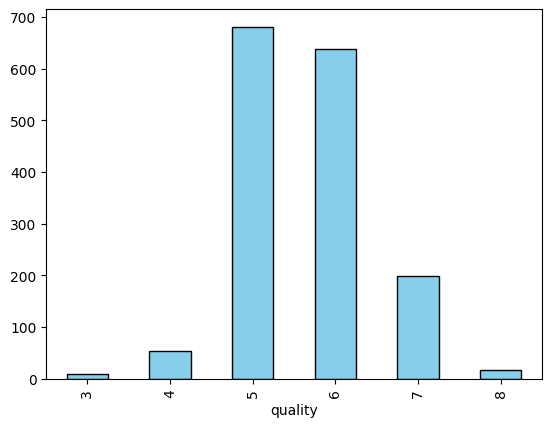

In [35]:
import matplotlib.pyplot as plt

counts = df.value_counts(subset='quality').sort_index()

print(counts)

counts.plot(kind='bar', color='skyblue', edgecolor='black')

#### Split the data into the __predicting values__ `X` and the __target__ `y`
Drop also the columns which are not relevant for training a classifier, if any

The method "drop" of dataframes allows to drop either rows or columns
- the "axis" parameter chooses between dropping rows (axis=0) or columns (axis=1)

In [99]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['quality'])
y = df.drop(columns=df.columns[:len(df.columns)-1])
random_state=23

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.70, random_state=random_state)

print(len(X_train), len(X_test), len(y_train), len(y_test))

1119 480 1119 480


### Prepare the baseline: holdout method

In [100]:
model = DecisionTreeClassifier(random_state=random_state)

- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(random_state = random_state)`
- Fit the estimator on the train data and target

In [101]:
model.fit(X_train, y_train)

score = accuracy_score(y_train, model.predict(X_train))

print(f"trained data accuracy score {score*100:.2f}%")

trained data accuracy score 100.00%


Let's see how it works on test data, and, comparing with the result on training data, see if you can suspect *overfitting*
- use the fitted estimator to predict using the test features
- compute the accuracy and store it on a variable for the final summary
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

In [102]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

fitted_max_depth = model.tree_.max_depth

print(f"Accuracy on test set: {accuracy*100:.1f}%")
print(f"Maximum depth of the tree: {fitted_max_depth}")

Accuracy on test set: 61.3%
Maximum depth of the tree: 21


Prepare the decision tree parameters and the scores 

In [76]:
# Set the parameters to be explored during the rounds of cross-validation
tuned_param_dt = [
    {
    'max_depth': list(range(1,fitted_max_depth+1)),
    'criterion' : ['entropy', 'gini'],
    'class_weight' : [None, 'balanced']
    }
]

# Set the different scores that will be optimised
scores = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

print(tuned_param_dt, scores)

[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 'criterion': ['entropy', 'gini'], 'class_weight': [None, 'balanced']}] ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']


### Loop on scores
- iterate varying the score function
    - fit the estimator using the training data
        - the resulting model will be the best one according to the current score function
    - print the best estimator
    - print the best score
    - predict the target for the test set using the `.predict` method
    - print the `classification report`
    - display the confusion matrix with `ConfusionMatrixDisplay`


Optimizing for: accuracy
Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best Estimator: DecisionTreeClassifier(max_depth=18, random_state=23)
Best Cross-Validated (SCORE) Accuracy: 56.2%
Best Params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 18}

Accuracy Score Report:
0.6145833333333334

Classification Report:
              precision    recall  f1-score   support

           3       0.33      0.33      0.33         3
           4       0.08      0.08      0.08        13
           5       0.71      0.68      0.70       207
           6       0.62      0.61      0.61       200
           7       0.49      0.55      0.52        53
           8       0.10      0.25      0.14         4

    accuracy                           0.61       480
   macro avg       0.39      0.42      0.40       480
weighted avg       0.62      0.61      0.62       480


Optimizing for: precision_macro
Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best Estimator: De

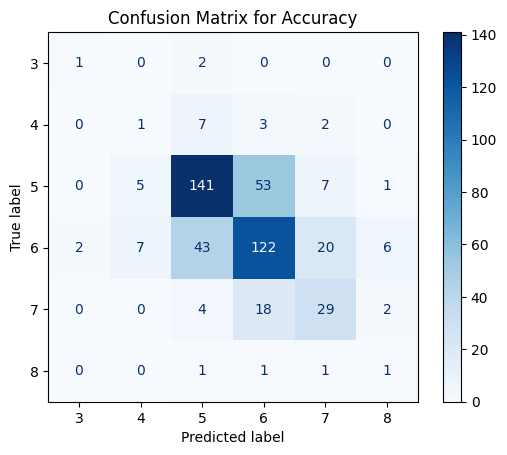

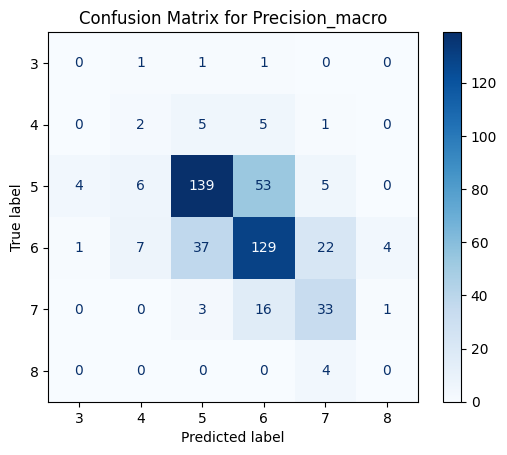

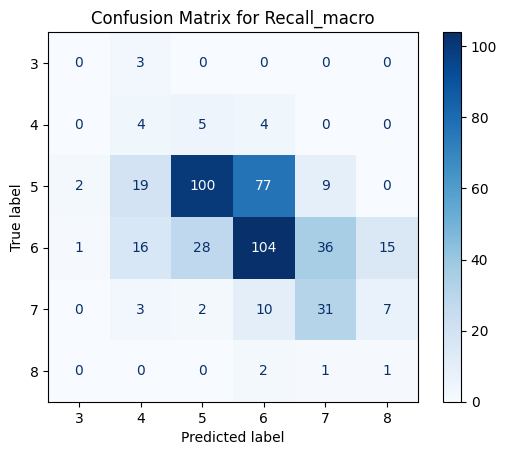

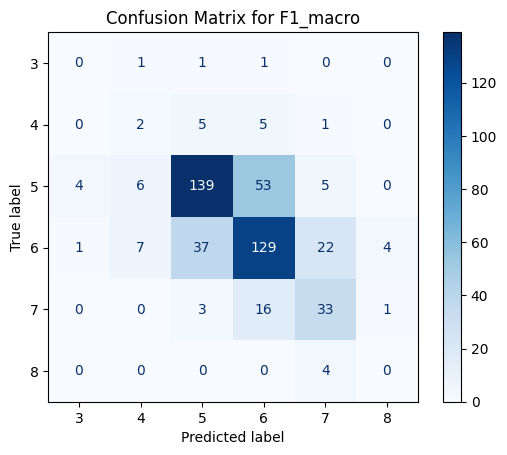

In [113]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

skf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)

for score in scores:
    print(f"\nOptimizing for: {score}\n" + "=" * 30)

    # Perform GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=tuned_param_dt,
        scoring=score,
        cv=skf,        # 5-fold cross-validation
        verbose=1,
        return_train_score=False
    )
    grid_search.fit(X_train, y_train)

    # Print the best estimator and best score
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    print(f"Best Estimator: {best_model}")
    print(f"Best Cross-Validated (SCORE) {score.capitalize()}: {best_score*100:.1f}%")
    print(f"Best Params: {best_params}")

    # Predict on the test set
    y_test_pred = best_model.predict(X_test)

    print("\nAccuracy Score Report:")
    print(accuracy_score(y_test, y_test_pred))
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(cmap='Blues')
    disp.ax_.set_title(f"Confusion Matrix for {score.capitalize()}")
    disp.figure_.show()

In [111]:
grid_search.best_params_

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 15}